### cnn을 이용해서 패치의 평균 값을 예측

In [1]:
import os
import torch
from torchvision import transforms
from utils.utils import train_model, TiffDataset, DualTransform, process_large_image, visualize_result, he_init_weights
from models.cnn import CNNRegressor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import rasterio
import gc

In [2]:
large_tif_dir = "../../data/source_data/with_s2/"  # 원천 데이터 TIFF 파일이 있는 폴더
file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"]  # 사용할 TIFF 파일 리스트
checkpoints_dir = "./checkpoints/use_patch" #check point 저장할 폴더
os.makedirs(checkpoints_dir, exist_ok=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 데이터 전처리 방법 설정

In [4]:
source_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환 -> squeeze
])

label_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float().mean(dim=[1, 2], keepdim=False))  # 평균 계산 후 (1,) 유지
])

# DualTransform을 적용하여 입력과 레이블을 변환
dual_transform = DualTransform(source_transform, label_transform)

### test 지역 선별 방법

In [5]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5) #test지역 선별

## target: height

In [6]:
# 데이터 경로 설정
target = "height"
label_dir = f"../../data/label_data/{target}"  # 대응하는 레이블 TIFF 파일이 있는 폴더

In [7]:
patch_size = 5
stride = 5

# 데이터셋 생성
train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: not test_filter(box_number), transform=dual_transform)
val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=test_filter, transform=dual_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [8]:
model = CNNRegressor().to(device)
model.apply(he_init_weights)

# 손실 함수
criterion = nn.MSELoss()  # 평균제곱오차 손실

# 옵티마이저 (Adam 추천)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 50

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100, task_type = "r"
)
model.load_state_dict(best_model_state)

torch.save(best_model_state, os.path.join(checkpoints_dir, f"cnn_{target}_{patch_size}_{num_epochs}.pth"))

Epoch 1/1 - Training:   0%|          | 0/26325 [00:00<?, ?it/s]

Epoch 1/1 - Validation: 100%|██████████| 7425/7425 [00:21<00:00, 341.26it/s]



Epoch [1/1], Train Loss: 12.4073, Train R² Score: 0.5016, Val Loss: 14.6844, Val R² Score: 0.3847



In [10]:
result = process_large_image(model, "../../data/source_data/with_s2/jiri_1.tif", patch_size=patch_size, stride=3)
visualize_result(result, "Model Prediction")

 35%|███▍      | 346141/1000000 [07:37<14:24, 756.60it/s]


KeyboardInterrupt: 

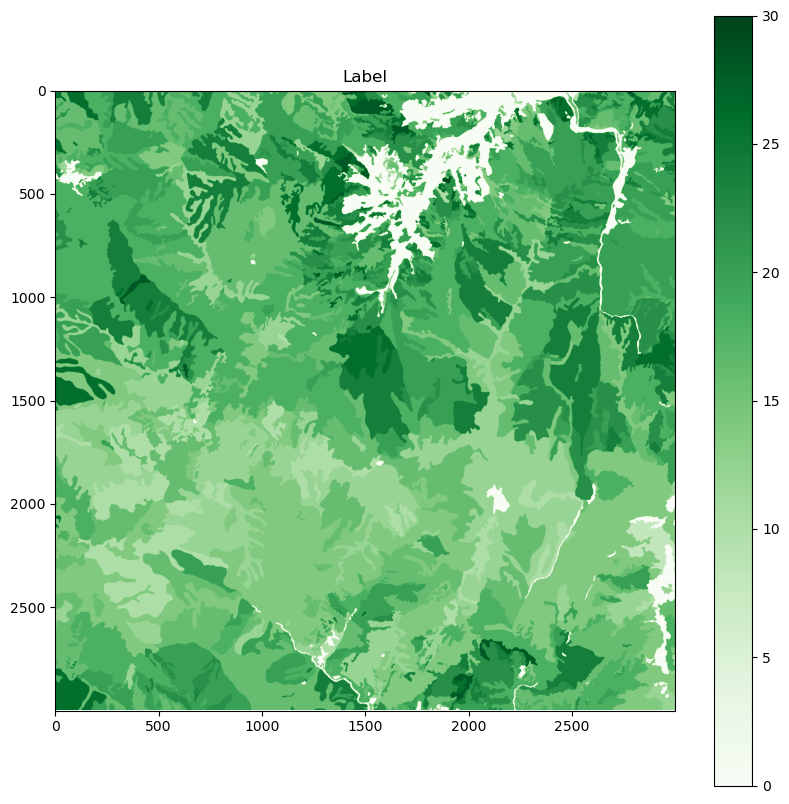

In [ ]:
with rasterio.open("../../data/label_data/height/jiri_1.tif") as src:
    image = src.read()
visualize_result(image, "Label") 

In [6]:
del model, train_loader, val_loader, train_dataset, val_dataset, criterion, optimizer
torch.cuda.empty_cache()  # GPU 캐시 정리
gc.collect()  # Python 가비지 컬렉터 실행

NameError: name 'model' is not defined

## target: density

In [8]:
target = "density"
label_dir = f"../../data/label_data/{target}"  # 대응하는 레이블 TIFF 파일이 있는 폴더

In [9]:
patch_size = 5
stride = 5

# 데이터셋 생성
train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: not test_filter(box_number), transform=dual_transform)
val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=test_filter, transform=dual_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [10]:
model = CNNRegressor().to(device)
model.apply(he_init_weights)

# 손실 함수
criterion = nn.MSELoss()  # 평균제곱오차 손실

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
num_epochs = 50

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100, task_type = "r"
)
model.load_state_dict(best_model_state)

torch.save(best_model_state, os.path.join(checkpoints_dir, f"cnn_{target}_{patch_size}_{num_epochs}.pth"))

Epoch 1/50 - Validation: 100%|██████████| 7425/7425 [01:28<00:00, 84.08it/s]



Epoch [1/50], Train Loss: 0.0078, Train R² Score: 0.6826, Val Loss: 0.0075, Val R² Score: 0.5170



Epoch 2/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.46it/s]



Epoch [2/50], Train Loss: 0.0059, Train R² Score: 0.7572, Val Loss: 0.0072, Val R² Score: 0.5408



Epoch 3/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 116.71it/s]



Epoch [3/50], Train Loss: 0.0054, Train R² Score: 0.7771, Val Loss: 0.0074, Val R² Score: 0.5234



Epoch 4/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 115.78it/s]



Epoch [4/50], Train Loss: 0.0052, Train R² Score: 0.7876, Val Loss: 0.0073, Val R² Score: 0.5330



Epoch 5/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.12it/s]



Epoch [5/50], Train Loss: 0.0050, Train R² Score: 0.7966, Val Loss: 0.0071, Val R² Score: 0.5425



Epoch 6/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 115.34it/s]



Epoch [6/50], Train Loss: 0.0048, Train R² Score: 0.8034, Val Loss: 0.0072, Val R² Score: 0.5383



Epoch 7/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 115.72it/s]



Epoch [7/50], Train Loss: 0.0047, Train R² Score: 0.8090, Val Loss: 0.0069, Val R² Score: 0.5556



Epoch 8/50 - Validation: 100%|██████████| 7425/7425 [01:02<00:00, 117.99it/s]



Epoch [8/50], Train Loss: 0.0045, Train R² Score: 0.8147, Val Loss: 0.0072, Val R² Score: 0.5369



Epoch 9/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.13it/s]



Epoch [9/50], Train Loss: 0.0044, Train R² Score: 0.8193, Val Loss: 0.0070, Val R² Score: 0.5514



Epoch 10/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.53it/s]



Epoch [10/50], Train Loss: 0.0043, Train R² Score: 0.8229, Val Loss: 0.0070, Val R² Score: 0.5489



Epoch 11/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.26it/s]



Epoch [11/50], Train Loss: 0.0042, Train R² Score: 0.8265, Val Loss: 0.0070, Val R² Score: 0.5532



Epoch 12/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.19it/s]



Epoch [12/50], Train Loss: 0.0042, Train R² Score: 0.8298, Val Loss: 0.0081, Val R² Score: 0.4805



Epoch 13/50 - Validation: 100%|██████████| 7425/7425 [01:02<00:00, 118.60it/s]



Epoch [13/50], Train Loss: 0.0041, Train R² Score: 0.8332, Val Loss: 0.0072, Val R² Score: 0.5379



Epoch 14/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 116.42it/s]



Epoch [14/50], Train Loss: 0.0040, Train R² Score: 0.8356, Val Loss: 0.0070, Val R² Score: 0.5522



Epoch 15/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.61it/s]



Epoch [15/50], Train Loss: 0.0039, Train R² Score: 0.8388, Val Loss: 0.0073, Val R² Score: 0.5355



Epoch 16/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.59it/s]



Epoch [16/50], Train Loss: 0.0039, Train R² Score: 0.8401, Val Loss: 0.0075, Val R² Score: 0.5196



Epoch 17/50 - Validation: 100%|██████████| 7425/7425 [01:02<00:00, 118.72it/s]



Epoch [17/50], Train Loss: 0.0038, Train R² Score: 0.8430, Val Loss: 0.0071, Val R² Score: 0.5471



Epoch 18/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.10it/s]



Epoch [18/50], Train Loss: 0.0038, Train R² Score: 0.8460, Val Loss: 0.0073, Val R² Score: 0.5355



Epoch 19/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.24it/s]



Epoch [19/50], Train Loss: 0.0037, Train R² Score: 0.8474, Val Loss: 0.0069, Val R² Score: 0.5588



Epoch 20/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.21it/s]



Epoch [20/50], Train Loss: 0.0037, Train R² Score: 0.8492, Val Loss: 0.0070, Val R² Score: 0.5508



Epoch 21/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.37it/s]



Epoch [21/50], Train Loss: 0.0036, Train R² Score: 0.8511, Val Loss: 0.0070, Val R² Score: 0.5494



Epoch 22/50 - Validation: 100%|██████████| 7425/7425 [01:02<00:00, 118.35it/s]



Epoch [22/50], Train Loss: 0.0036, Train R² Score: 0.8532, Val Loss: 0.0068, Val R² Score: 0.5625



Epoch 23/50 - Validation: 100%|██████████| 7425/7425 [01:02<00:00, 118.37it/s]



Epoch [23/50], Train Loss: 0.0035, Train R² Score: 0.8559, Val Loss: 0.0069, Val R² Score: 0.5590



Epoch 24/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.37it/s]



Epoch [24/50], Train Loss: 0.0035, Train R² Score: 0.8578, Val Loss: 0.0070, Val R² Score: 0.5508



Epoch 25/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 116.73it/s]



Epoch [25/50], Train Loss: 0.0035, Train R² Score: 0.8582, Val Loss: 0.0070, Val R² Score: 0.5519



Epoch 26/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.12it/s]



Epoch [26/50], Train Loss: 0.0034, Train R² Score: 0.8600, Val Loss: 0.0070, Val R² Score: 0.5525



Epoch 27/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.35it/s]



Epoch [27/50], Train Loss: 0.0034, Train R² Score: 0.8610, Val Loss: 0.0072, Val R² Score: 0.5378



Epoch 28/50 - Validation: 100%|██████████| 7425/7425 [01:02<00:00, 118.59it/s]



Epoch [28/50], Train Loss: 0.0033, Train R² Score: 0.8630, Val Loss: 0.0072, Val R² Score: 0.5397



Epoch 29/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.16it/s]



Epoch [29/50], Train Loss: 0.0033, Train R² Score: 0.8639, Val Loss: 0.0070, Val R² Score: 0.5522



Epoch 30/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.23it/s]



Epoch [30/50], Train Loss: 0.0033, Train R² Score: 0.8656, Val Loss: 0.0071, Val R² Score: 0.5466



Epoch 31/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.23it/s]



Epoch [31/50], Train Loss: 0.0033, Train R² Score: 0.8662, Val Loss: 0.0073, Val R² Score: 0.5297



Epoch 32/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.04it/s]



Epoch [32/50], Train Loss: 0.0032, Train R² Score: 0.8679, Val Loss: 0.0072, Val R² Score: 0.5362



Epoch 33/50 - Validation: 100%|██████████| 7425/7425 [01:02<00:00, 118.18it/s]



Epoch [33/50], Train Loss: 0.0032, Train R² Score: 0.8695, Val Loss: 0.0071, Val R² Score: 0.5436



Epoch 34/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 117.45it/s]



Epoch [34/50], Train Loss: 0.0032, Train R² Score: 0.8704, Val Loss: 0.0069, Val R² Score: 0.5585



Epoch 35/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 115.82it/s]



Epoch [35/50], Train Loss: 0.0032, Train R² Score: 0.8703, Val Loss: 0.0070, Val R² Score: 0.5494



Epoch 36/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 116.52it/s]



Epoch [36/50], Train Loss: 0.0031, Train R² Score: 0.8719, Val Loss: 0.0068, Val R² Score: 0.5625



Epoch 37/50 - Validation: 100%|██████████| 7425/7425 [01:14<00:00, 99.69it/s] 



Epoch [37/50], Train Loss: 0.0031, Train R² Score: 0.8734, Val Loss: 0.0077, Val R² Score: 0.5050



Epoch 38/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 115.77it/s]



Epoch [38/50], Train Loss: 0.0031, Train R² Score: 0.8745, Val Loss: 0.0068, Val R² Score: 0.5620



Epoch 39/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 115.72it/s]



Epoch [39/50], Train Loss: 0.0030, Train R² Score: 0.8756, Val Loss: 0.0072, Val R² Score: 0.5402



Epoch 40/50 - Validation: 100%|██████████| 7425/7425 [01:15<00:00, 97.99it/s] 



Epoch [40/50], Train Loss: 0.0030, Train R² Score: 0.8766, Val Loss: 0.0074, Val R² Score: 0.5282



Epoch 41/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 114.85it/s]



Epoch [41/50], Train Loss: 0.0030, Train R² Score: 0.8777, Val Loss: 0.0080, Val R² Score: 0.4850



Epoch 42/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 114.78it/s]



Epoch [42/50], Train Loss: 0.0030, Train R² Score: 0.8789, Val Loss: 0.0072, Val R² Score: 0.5370



Epoch 43/50 - Validation: 100%|██████████| 7425/7425 [01:05<00:00, 113.30it/s]



Epoch [43/50], Train Loss: 0.0029, Train R² Score: 0.8806, Val Loss: 0.0068, Val R² Score: 0.5680



Epoch 44/50 - Validation: 100%|██████████| 7425/7425 [01:07<00:00, 110.28it/s]



Epoch [44/50], Train Loss: 0.0029, Train R² Score: 0.8806, Val Loss: 0.0068, Val R² Score: 0.5649



Epoch 45/50 - Validation: 100%|██████████| 7425/7425 [01:26<00:00, 85.78it/s] 



Epoch [45/50], Train Loss: 0.0029, Train R² Score: 0.8813, Val Loss: 0.0066, Val R² Score: 0.5784



Epoch 46/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 114.97it/s]



Epoch [46/50], Train Loss: 0.0029, Train R² Score: 0.8815, Val Loss: 0.0069, Val R² Score: 0.5554



Epoch 47/50 - Validation: 100%|██████████| 7425/7425 [01:03<00:00, 116.42it/s]



Epoch [47/50], Train Loss: 0.0029, Train R² Score: 0.8815, Val Loss: 0.0072, Val R² Score: 0.5399



Epoch 48/50 - Validation: 100%|██████████| 7425/7425 [01:08<00:00, 108.60it/s]



Epoch [48/50], Train Loss: 0.0028, Train R² Score: 0.8838, Val Loss: 0.0076, Val R² Score: 0.5154



Epoch 49/50 - Validation: 100%|██████████| 7425/7425 [01:12<00:00, 102.20it/s]



Epoch [49/50], Train Loss: 0.0028, Train R² Score: 0.8840, Val Loss: 0.0069, Val R² Score: 0.5612



Epoch 50/50 - Validation: 100%|██████████| 7425/7425 [01:06<00:00, 111.79it/s]



Epoch [50/50], Train Loss: 0.0028, Train R² Score: 0.8851, Val Loss: 0.0071, Val R² Score: 0.5460



100%|██████████| 1000000/1000000 [34:48<00:00, 478.91it/s]


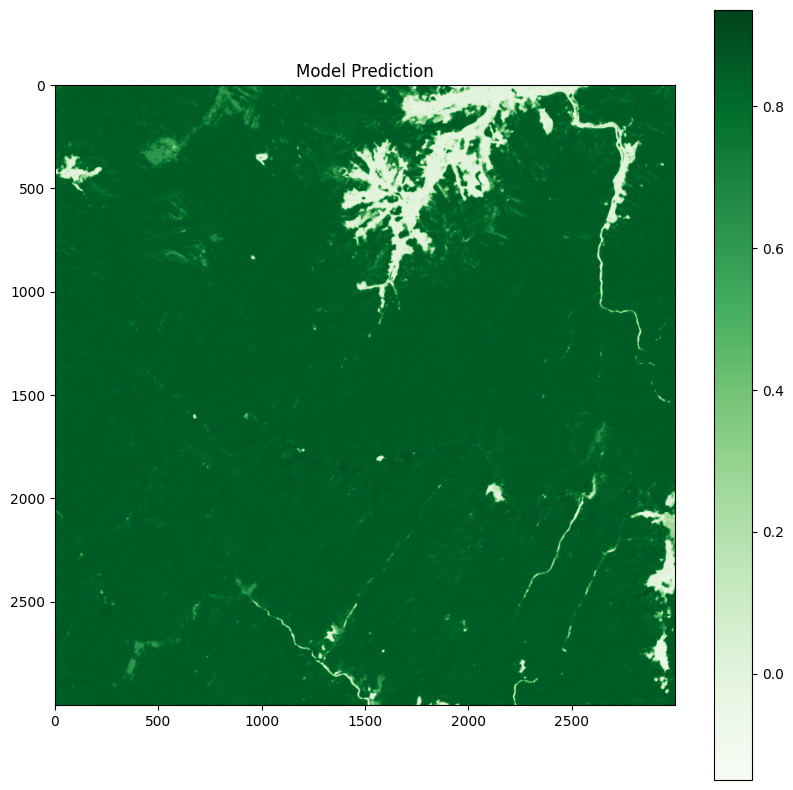

In [12]:
result = process_large_image(model, "../../data/source_data/with_s2/jiri_1.tif", patch_size=patch_size, stride=3)
visualize_result(result, "Model Prediction")

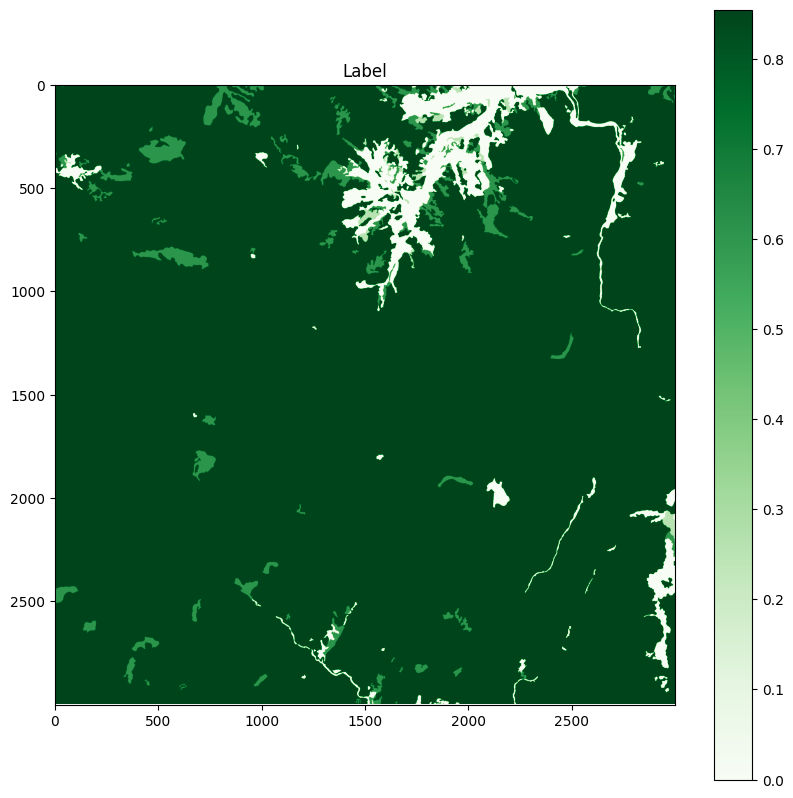

In [13]:
with rasterio.open("../../data/label_data/density/jiri_1.tif") as src:
    image = src.read()
visualize_result(image, "Label") 

In [ ]:
del model, train_loader, val_loader, train_dataset, val_dataset, criterion, optimizer
torch.cuda.empty_cache()  # GPU 캐시 정리
gc.collect()  # Python 가비지 컬렉터 실행

11051

### target: DBH

In [14]:
target = "DBH"
label_dir = f"../../data/label_data/{target}"  # 대응하는 레이블 TIFF 파일이 있는 폴더

In [15]:
patch_size = 5
stride = 5

# 데이터셋 생성
train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: not test_filter(box_number), transform=dual_transform)
val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=test_filter, transform=dual_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [16]:
model = CNNRegressor().to(device)
model.apply(he_init_weights)

# 손실 함수
criterion = nn.MSELoss()  # 평균제곱오차 손실

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
num_epochs = 50

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100, task_type = "r"
)
model.load_state_dict(best_model_state)


Epoch 1/50 - Training:   0%|          | 0/26325 [00:00<?, ?it/s]

Epoch 1/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 107.55it/s]



Epoch [1/50], Train Loss: 16.2827, Train R² Score: 0.4555, Val Loss: 13.9367, Val R² Score: 0.4431



Epoch 2/50 - Validation: 100%|██████████| 7425/7425 [01:07<00:00, 110.24it/s]



Epoch [2/50], Train Loss: 12.0176, Train R² Score: 0.5981, Val Loss: 15.2399, Val R² Score: 0.3910



Epoch 3/50 - Validation: 100%|██████████| 7425/7425 [01:07<00:00, 109.97it/s]



Epoch [3/50], Train Loss: 11.1040, Train R² Score: 0.6287, Val Loss: 13.7148, Val R² Score: 0.4520



Epoch 4/50 - Validation: 100%|██████████| 7425/7425 [01:07<00:00, 110.03it/s]



Epoch [4/50], Train Loss: 10.4439, Train R² Score: 0.6507, Val Loss: 14.0926, Val R² Score: 0.4369



Epoch 5/50 - Validation: 100%|██████████| 7425/7425 [01:06<00:00, 111.26it/s]



Epoch [5/50], Train Loss: 9.9909, Train R² Score: 0.6659, Val Loss: 14.7359, Val R² Score: 0.4112



Epoch 6/50 - Validation: 100%|██████████| 7425/7425 [01:04<00:00, 114.34it/s]



Epoch [6/50], Train Loss: 9.5802, Train R² Score: 0.6796, Val Loss: 14.2417, Val R² Score: 0.4309



Epoch 7/50 - Validation: 100%|██████████| 7425/7425 [01:18<00:00, 94.12it/s] 



Epoch [7/50], Train Loss: 9.2928, Train R² Score: 0.6892, Val Loss: 14.0588, Val R² Score: 0.4382



Epoch 8/50 - Validation: 100%|██████████| 7425/7425 [01:06<00:00, 111.24it/s]



Epoch [8/50], Train Loss: 9.0800, Train R² Score: 0.6963, Val Loss: 13.9095, Val R² Score: 0.4442



Epoch 9/50 - Validation: 100%|██████████| 7425/7425 [01:06<00:00, 111.61it/s]



Epoch [9/50], Train Loss: 8.8467, Train R² Score: 0.7041, Val Loss: 13.4991, Val R² Score: 0.4606



Epoch 10/50 - Validation: 100%|██████████| 7425/7425 [01:22<00:00, 89.51it/s] 



Epoch [10/50], Train Loss: 8.6365, Train R² Score: 0.7112, Val Loss: 13.9601, Val R² Score: 0.4422



Epoch 11/50 - Validation: 100%|██████████| 7425/7425 [01:07<00:00, 109.28it/s]



Epoch [11/50], Train Loss: 8.4856, Train R² Score: 0.7162, Val Loss: 13.8296, Val R² Score: 0.4474



Epoch 12/50 - Validation: 100%|██████████| 7425/7425 [01:08<00:00, 107.66it/s]



Epoch [12/50], Train Loss: 8.3146, Train R² Score: 0.7219, Val Loss: 13.9340, Val R² Score: 0.4432



Epoch 13/50 - Validation: 100%|██████████| 7425/7425 [01:07<00:00, 109.80it/s]



Epoch [13/50], Train Loss: 8.1944, Train R² Score: 0.7260, Val Loss: 14.8033, Val R² Score: 0.4085



Epoch 14/50 - Validation: 100%|██████████| 7425/7425 [01:16<00:00, 96.96it/s] 



Epoch [14/50], Train Loss: 8.0336, Train R² Score: 0.7313, Val Loss: 13.8261, Val R² Score: 0.4475



Epoch 15/50 - Validation: 100%|██████████| 7425/7425 [01:12<00:00, 101.78it/s]



Epoch [15/50], Train Loss: 7.9167, Train R² Score: 0.7352, Val Loss: 13.5534, Val R² Score: 0.4584



Epoch 16/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 107.53it/s]



Epoch [16/50], Train Loss: 7.8030, Train R² Score: 0.7390, Val Loss: 13.8405, Val R² Score: 0.4470



Epoch 17/50 - Validation: 100%|██████████| 7425/7425 [01:34<00:00, 78.31it/s]



Epoch [17/50], Train Loss: 7.6664, Train R² Score: 0.7436, Val Loss: 13.9200, Val R² Score: 0.4438



Epoch 18/50 - Validation: 100%|██████████| 7425/7425 [01:08<00:00, 108.09it/s]



Epoch [18/50], Train Loss: 7.5812, Train R² Score: 0.7465, Val Loss: 13.8666, Val R² Score: 0.4459



Epoch 19/50 - Validation: 100%|██████████| 7425/7425 [01:13<00:00, 100.35it/s]



Epoch [19/50], Train Loss: 7.5055, Train R² Score: 0.7490, Val Loss: 13.6713, Val R² Score: 0.4537



Epoch 20/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.31it/s]



Epoch [20/50], Train Loss: 7.3877, Train R² Score: 0.7529, Val Loss: 13.5008, Val R² Score: 0.4605



Epoch 21/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.95it/s]



Epoch [21/50], Train Loss: 7.3062, Train R² Score: 0.7557, Val Loss: 13.6788, Val R² Score: 0.4534



Epoch 22/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 104.93it/s]



Epoch [22/50], Train Loss: 7.2467, Train R² Score: 0.7577, Val Loss: 14.9772, Val R² Score: 0.4015



Epoch 23/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.11it/s]



Epoch [23/50], Train Loss: 7.1690, Train R² Score: 0.7603, Val Loss: 15.2341, Val R² Score: 0.3913



Epoch 24/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 107.27it/s]



Epoch [24/50], Train Loss: 7.0743, Train R² Score: 0.7634, Val Loss: 13.6448, Val R² Score: 0.4548



Epoch 25/50 - Validation: 100%|██████████| 7425/7425 [01:11<00:00, 104.09it/s]



Epoch [25/50], Train Loss: 6.9963, Train R² Score: 0.7660, Val Loss: 14.2843, Val R² Score: 0.4292



Epoch 26/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.64it/s]



Epoch [26/50], Train Loss: 6.9365, Train R² Score: 0.7680, Val Loss: 13.7529, Val R² Score: 0.4505



Epoch 27/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.94it/s]



Epoch [27/50], Train Loss: 6.8547, Train R² Score: 0.7708, Val Loss: 13.7825, Val R² Score: 0.4493



Epoch 28/50 - Validation: 100%|██████████| 7425/7425 [01:14<00:00, 99.11it/s] 



Epoch [28/50], Train Loss: 6.7939, Train R² Score: 0.7728, Val Loss: 13.6648, Val R² Score: 0.4540



Epoch 29/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.73it/s]



Epoch [29/50], Train Loss: 6.7597, Train R² Score: 0.7739, Val Loss: 13.8632, Val R² Score: 0.4461



Epoch 30/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.94it/s]



Epoch [30/50], Train Loss: 6.6871, Train R² Score: 0.7764, Val Loss: 13.8065, Val R² Score: 0.4483



Epoch 31/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.72it/s]



Epoch [31/50], Train Loss: 6.6257, Train R² Score: 0.7784, Val Loss: 14.1128, Val R² Score: 0.4361



Epoch 32/50 - Validation: 100%|██████████| 7425/7425 [01:11<00:00, 104.52it/s]



Epoch [32/50], Train Loss: 6.5747, Train R² Score: 0.7801, Val Loss: 13.5813, Val R² Score: 0.4573



Epoch 33/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.52it/s]



Epoch [33/50], Train Loss: 6.5104, Train R² Score: 0.7823, Val Loss: 13.7759, Val R² Score: 0.4495



Epoch 34/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.39it/s]



Epoch [34/50], Train Loss: 6.4695, Train R² Score: 0.7836, Val Loss: 13.5709, Val R² Score: 0.4577



Epoch 35/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 106.07it/s]



Epoch [35/50], Train Loss: 6.3878, Train R² Score: 0.7864, Val Loss: 13.7030, Val R² Score: 0.4525



Epoch 36/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 107.32it/s]



Epoch [36/50], Train Loss: 6.3527, Train R² Score: 0.7875, Val Loss: 14.1733, Val R² Score: 0.4337



Epoch 37/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.50it/s]



Epoch [37/50], Train Loss: 6.3079, Train R² Score: 0.7890, Val Loss: 14.0676, Val R² Score: 0.4379



Epoch 38/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.93it/s]



Epoch [38/50], Train Loss: 6.2568, Train R² Score: 0.7908, Val Loss: 13.3431, Val R² Score: 0.4668



Epoch 39/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 107.35it/s]



Epoch [39/50], Train Loss: 6.2118, Train R² Score: 0.7923, Val Loss: 14.4687, Val R² Score: 0.4219



Epoch 40/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.57it/s]



Epoch [40/50], Train Loss: 6.1432, Train R² Score: 0.7946, Val Loss: 13.3842, Val R² Score: 0.4652



Epoch 41/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 104.68it/s]



Epoch [41/50], Train Loss: 6.1098, Train R² Score: 0.7957, Val Loss: 14.1218, Val R² Score: 0.4357



Epoch 42/50 - Validation: 100%|██████████| 7425/7425 [01:11<00:00, 104.02it/s]



Epoch [42/50], Train Loss: 6.0616, Train R² Score: 0.7973, Val Loss: 13.3550, Val R² Score: 0.4664



Epoch 43/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.10it/s]



Epoch [43/50], Train Loss: 6.0491, Train R² Score: 0.7977, Val Loss: 13.9874, Val R² Score: 0.4411



Epoch 44/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.62it/s]



Epoch [44/50], Train Loss: 5.9871, Train R² Score: 0.7998, Val Loss: 13.8124, Val R² Score: 0.4481



Epoch 45/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 106.00it/s]



Epoch [45/50], Train Loss: 5.9421, Train R² Score: 0.8013, Val Loss: 13.6081, Val R² Score: 0.4563



Epoch 46/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.75it/s]



Epoch [46/50], Train Loss: 5.8998, Train R² Score: 0.8027, Val Loss: 13.5090, Val R² Score: 0.4602



Epoch 47/50 - Validation: 100%|██████████| 7425/7425 [01:10<00:00, 105.43it/s]



Epoch [47/50], Train Loss: 5.8639, Train R² Score: 0.8039, Val Loss: 13.3535, Val R² Score: 0.4664



Epoch 48/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 106.48it/s]



Epoch [48/50], Train Loss: 5.8262, Train R² Score: 0.8052, Val Loss: 13.8049, Val R² Score: 0.4484



Epoch 49/50 - Validation: 100%|██████████| 7425/7425 [01:09<00:00, 107.20it/s]



Epoch [49/50], Train Loss: 5.7902, Train R² Score: 0.8064, Val Loss: 14.1319, Val R² Score: 0.4353



Epoch 50/50 - Validation: 100%|██████████| 7425/7425 [02:53<00:00, 42.79it/s]



Epoch [50/50], Train Loss: 5.7597, Train R² Score: 0.8074, Val Loss: 14.0813, Val R² Score: 0.4373



<All keys matched successfully>

100%|██████████| 1000000/1000000 [1:05:13<00:00, 255.54it/s]


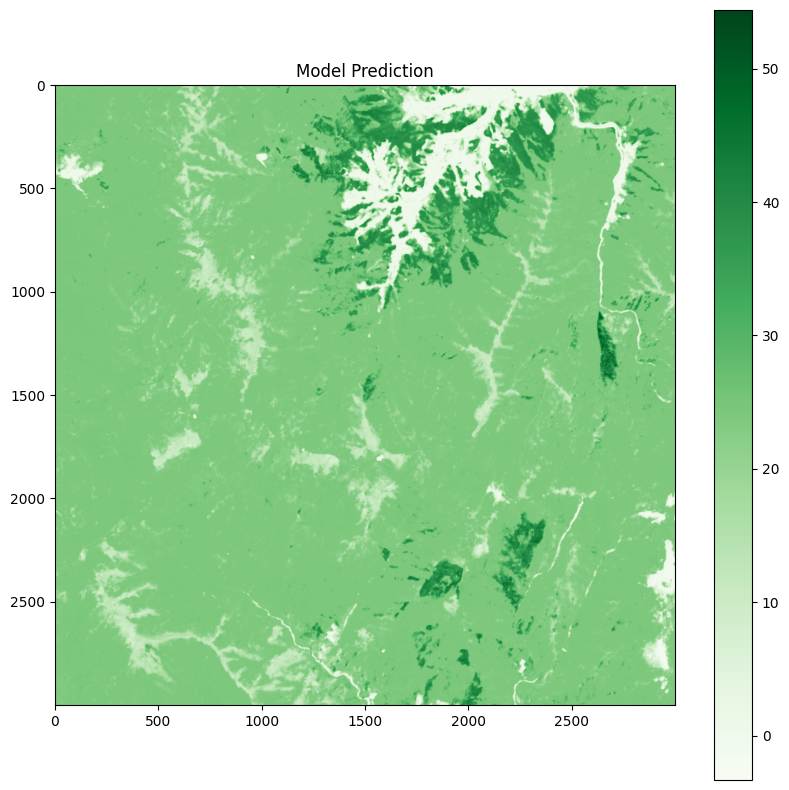

In [18]:
result = process_large_image(model, "../../data/source_data/with_s2/jiri_1.tif", patch_size=patch_size, stride=3)
visualize_result(result, "Model Prediction")

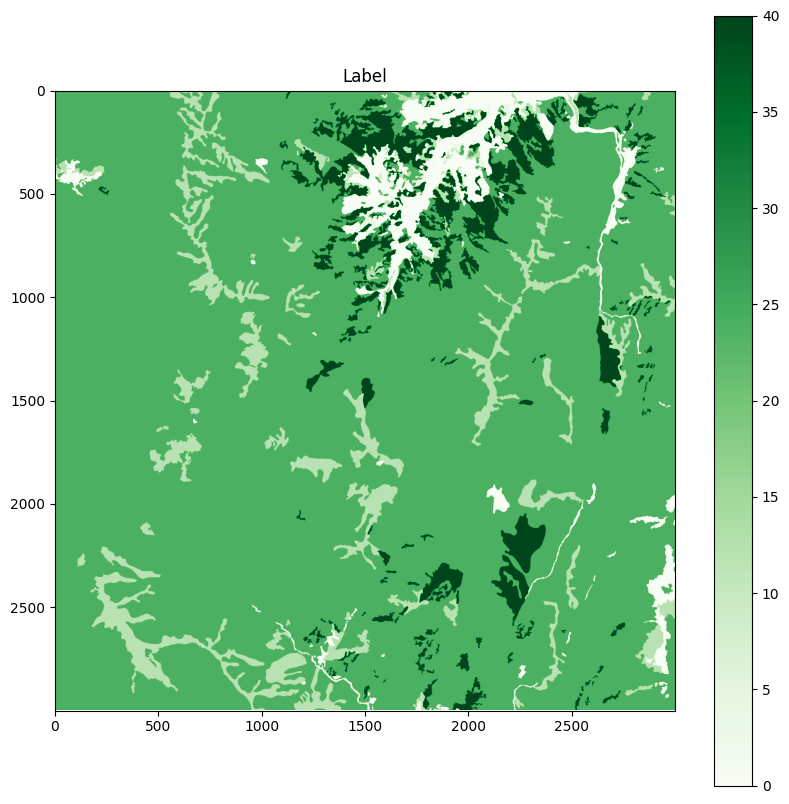

In [19]:
with rasterio.open("../../data/label_data/DBH/jiri_1.tif") as src:
    image = src.read()
visualize_result(image, "Label") 

======================================================================================================================================